# News Summarization with an Attention Mechanism
Author: Andrii Zapukhlyi

## Objective

## Solution

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

## Dataset overview

In [3]:
df = datasets.load_dataset('cnn_dailymail', '3.0.0')

Generating test split: 100%|██████████| 11490/11490 [00:00<00:00, 207904.85 examples/s]


In [11]:
train = pd.DataFrame(df['train'])
val = pd.DataFrame(df['validation'])
test = pd.DataFrame(df['test'])

In [20]:
train.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [15]:
print(len(train), len(val), len(test))

287113 13368 11490


<Axes: ylabel='Frequency'>

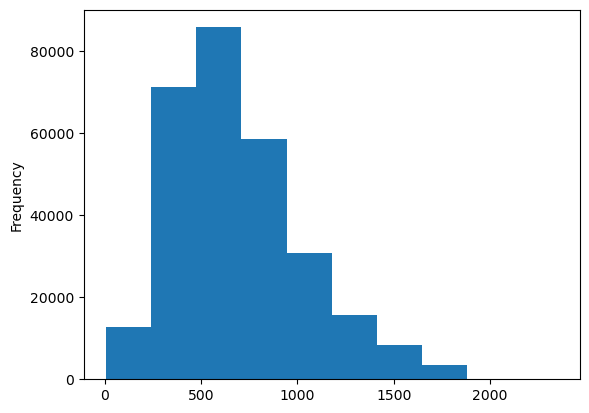

In [19]:
train["article"].apply(lambda x: len(x.split())).plot(kind='hist')